In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
# import graphviz
from matplotlib import pyplot
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import codecs  
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('./data/used_car_train_20200313.csv',sep = ' ')

In [3]:
data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
data.dtypes

SaleID                 int64
name                   int64
regDate                int64
model                float64
brand                  int64
bodyType             float64
fuelType             float64
gearbox              float64
power                  int64
kilometer            float64
notRepairedDamage     object
regionCode             int64
seller                 int64
offerType              int64
creatDate              int64
price                  int64
v_0                  float64
v_1                  float64
v_2                  float64
v_3                  float64
v_4                  float64
v_5                  float64
v_6                  float64
v_7                  float64
v_8                  float64
v_9                  float64
v_10                 float64
v_11                 float64
v_12                 float64
v_13                 float64
v_14                 float64
dtype: object

In [5]:
data.notRepairedDamage.unique()

array(['0.0', '-', '1.0'], dtype=object)

In [6]:
encoder = LabelEncoder()
encoder.fit_transform(data.notRepairedDamage)

array([1, 0, 1, ..., 1, 1, 1])

In [7]:
data_clean = data.copy()
data_clean['notRepairedDamage'] = encoder.fit_transform(data.notRepairedDamage)

In [8]:
data_clean.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [16]:
del X_train, X_test, y_train,y_test

In [17]:
X  = data_clean.drop(labels = ['SaleID','price','name'],axis = 1)
y = data_clean.price
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [18]:
X_train.shape,X_test.shape

((105000, 28), (45000, 28))

In [11]:
xgb_reg = xgb.XGBRegressor(silent=False,
                           learning_rate=0.1,
                           colsample_bytree=0.7,
                           subsample=0.8,
                           objective='reg:linear',
                           n_estimators=3000,
                           reg_alpha=0.3,
                           max_depth=5,
                           gamma=5,
                           eval_metric=['mae'],
                           n_jobs = -1)

In [12]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["mae"]
xgb_reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True,early_stopping_rounds= 100)

[17:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-mae:5314.02344	validation_1-mae:5369.00000
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[17:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-mae:4785.24170	validation_1-mae:4834.21143
[17:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-mae:4310.26953	validation_1-mae:4354.80957
[17:59:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-mae:3886.07568	validation_1-mae:3926.3247

[38]	validation_0-mae:782.87756	validation_1-mae:819.62756
[17:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[39]	validation_0-mae:778.79968	validation_1-mae:815.76446
[17:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[40]	validation_0-mae:775.21313	validation_1-mae:813.01538
[17:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[41]	validation_0-mae:772.08765	validation_1-mae:810.02142
[17:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[42]	validation_0-mae:769.66315	validation_1-mae:807.77673
[17:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[17:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[78]	validation_0-mae:700.03742	validation_1-mae:747.80438
[17:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[79]	validation_0-mae:699.50311	validation_1-mae:747.62366
[17:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[80]	validation_0-mae:699.06848	validation_1-mae:747.37060
[17:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[81]	validation_0-mae:697.77563	validation_1-mae:746.19336
[17:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[82]	vali

[17:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[117]	validation_0-mae:668.84003	validation_1-mae:724.77057
[17:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[118]	validation_0-mae:666.82440	validation_1-mae:722.80756
[17:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[119]	validation_0-mae:664.40698	validation_1-mae:720.31043
[17:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[120]	validation_0-mae:663.98969	validation_1-mae:720.08838
[17:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[121]

[17:59:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[156]	validation_0-mae:638.49176	validation_1-mae:700.43829
[17:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[157]	validation_0-mae:636.49536	validation_1-mae:698.42114
[17:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[158]	validation_0-mae:635.94134	validation_1-mae:698.05890
[17:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[159]	validation_0-mae:635.58612	validation_1-mae:698.06500
[17:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[160]

[17:59:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[195]	validation_0-mae:613.44916	validation_1-mae:681.56799
[17:59:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[196]	validation_0-mae:612.71906	validation_1-mae:680.99829
[17:59:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[197]	validation_0-mae:612.19434	validation_1-mae:680.57410
[17:59:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[198]	validation_0-mae:611.81397	validation_1-mae:680.29980
[17:59:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[199]

[17:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[234]	validation_0-mae:592.06757	validation_1-mae:665.31335
[17:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[235]	validation_0-mae:591.05847	validation_1-mae:664.37170
[17:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[236]	validation_0-mae:590.14844	validation_1-mae:663.67438
[17:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[237]	validation_0-mae:589.88721	validation_1-mae:663.55273
[17:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[238]

[17:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[273]	validation_0-mae:574.36566	validation_1-mae:652.93848
[17:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[274]	validation_0-mae:574.04791	validation_1-mae:652.74445
[17:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[275]	validation_0-mae:573.60266	validation_1-mae:652.36194
[17:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[276]	validation_0-mae:572.93463	validation_1-mae:651.91833
[17:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[277]

[17:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[312]	validation_0-mae:559.79279	validation_1-mae:642.70233
[17:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[313]	validation_0-mae:558.85236	validation_1-mae:641.84699
[17:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[314]	validation_0-mae:558.69830	validation_1-mae:641.74188
[17:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[315]	validation_0-mae:558.44818	validation_1-mae:641.59967
[17:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[316]

[17:59:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[351]	validation_0-mae:545.53809	validation_1-mae:634.25317
[17:59:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[352]	validation_0-mae:545.30981	validation_1-mae:634.04230
[17:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[353]	validation_0-mae:545.06836	validation_1-mae:633.97131
[17:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[354]	validation_0-mae:544.41773	validation_1-mae:633.44611
[17:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[355]

[17:59:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[390]	validation_0-mae:535.55371	validation_1-mae:629.29358
[17:59:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[391]	validation_0-mae:534.41144	validation_1-mae:628.24255
[17:59:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[392]	validation_0-mae:533.76746	validation_1-mae:627.72760
[17:59:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[393]	validation_0-mae:533.40540	validation_1-mae:627.38770
[17:59:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[394]

[17:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[429]	validation_0-mae:521.98151	validation_1-mae:619.62396
[17:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[430]	validation_0-mae:521.52094	validation_1-mae:619.39294
[17:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[431]	validation_0-mae:521.37073	validation_1-mae:619.41321
[17:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[432]	validation_0-mae:521.20575	validation_1-mae:619.49078
[17:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[433]

[17:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[468]	validation_0-mae:509.76929	validation_1-mae:612.17804
[17:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[469]	validation_0-mae:508.95898	validation_1-mae:611.52533
[17:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[470]	validation_0-mae:508.88028	validation_1-mae:611.49011
[17:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[471]	validation_0-mae:508.59375	validation_1-mae:611.30499
[17:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[472]

[17:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[507]	validation_0-mae:499.86877	validation_1-mae:606.80102
[17:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[508]	validation_0-mae:499.66892	validation_1-mae:606.65442
[17:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[509]	validation_0-mae:499.25357	validation_1-mae:606.38544
[17:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[510]	validation_0-mae:498.85703	validation_1-mae:606.08185
[17:59:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[511]

[18:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[546]	validation_0-mae:491.81097	validation_1-mae:602.69348
[18:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[547]	validation_0-mae:491.49753	validation_1-mae:602.45825
[18:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[548]	validation_0-mae:491.26071	validation_1-mae:602.31531
[18:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[549]	validation_0-mae:491.10294	validation_1-mae:602.32001
[18:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[550]

[18:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[585]	validation_0-mae:484.41760	validation_1-mae:599.38300
[18:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[586]	validation_0-mae:484.13101	validation_1-mae:599.13684
[18:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[587]	validation_0-mae:483.93372	validation_1-mae:599.10034
[18:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[588]	validation_0-mae:483.73535	validation_1-mae:599.05481
[18:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[589]

[18:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[624]	validation_0-mae:477.18793	validation_1-mae:596.50482
[18:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[625]	validation_0-mae:476.94635	validation_1-mae:596.34228
[18:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[626]	validation_0-mae:476.65405	validation_1-mae:596.16577
[18:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[627]	validation_0-mae:476.41199	validation_1-mae:596.06738
[18:00:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[628]

[18:00:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[663]	validation_0-mae:469.17602	validation_1-mae:593.27075
[18:00:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[664]	validation_0-mae:468.97366	validation_1-mae:593.16608
[18:00:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[665]	validation_0-mae:468.91281	validation_1-mae:593.14703
[18:00:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[666]	validation_0-mae:468.78186	validation_1-mae:593.17310
[18:00:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[667]

[18:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[702]	validation_0-mae:462.06000	validation_1-mae:590.07825
[18:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[703]	validation_0-mae:461.85330	validation_1-mae:590.03003
[18:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[704]	validation_0-mae:461.81586	validation_1-mae:590.01544
[18:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[705]	validation_0-mae:461.54459	validation_1-mae:589.80792
[18:00:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[706]

[18:00:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[741]	validation_0-mae:455.07422	validation_1-mae:586.39838
[18:00:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[742]	validation_0-mae:454.98877	validation_1-mae:586.35535
[18:00:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[743]	validation_0-mae:454.85318	validation_1-mae:586.38031
[18:00:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[744]	validation_0-mae:454.60111	validation_1-mae:586.20551
[18:00:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[745]

[18:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[780]	validation_0-mae:448.49878	validation_1-mae:583.41443
[18:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[781]	validation_0-mae:448.39731	validation_1-mae:583.39496
[18:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[782]	validation_0-mae:448.17658	validation_1-mae:583.26947
[18:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[783]	validation_0-mae:448.05649	validation_1-mae:583.18158
[18:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[784]

[18:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[819]	validation_0-mae:443.01083	validation_1-mae:581.47302
[18:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[820]	validation_0-mae:442.84442	validation_1-mae:581.37225
[18:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[821]	validation_0-mae:442.55386	validation_1-mae:581.18054
[18:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[822]	validation_0-mae:442.39957	validation_1-mae:581.10834
[18:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[823]

[18:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[858]	validation_0-mae:437.42343	validation_1-mae:579.50671
[18:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[859]	validation_0-mae:437.32001	validation_1-mae:579.54218
[18:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[860]	validation_0-mae:437.16495	validation_1-mae:579.54547
[18:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[861]	validation_0-mae:436.91681	validation_1-mae:579.39062
[18:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[862]

[18:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[897]	validation_0-mae:432.31955	validation_1-mae:577.87421
[18:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[898]	validation_0-mae:432.23102	validation_1-mae:577.90216
[18:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[899]	validation_0-mae:432.16327	validation_1-mae:577.88428
[18:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[900]	validation_0-mae:432.05750	validation_1-mae:577.83344
[18:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[901]

[18:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[936]	validation_0-mae:427.04514	validation_1-mae:575.81958
[18:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[937]	validation_0-mae:426.71527	validation_1-mae:575.56049
[18:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[938]	validation_0-mae:426.21414	validation_1-mae:575.12500
[18:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[939]	validation_0-mae:425.98560	validation_1-mae:575.00104
[18:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[940]

[18:00:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[975]	validation_0-mae:420.57398	validation_1-mae:572.36090
[18:00:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[976]	validation_0-mae:420.45154	validation_1-mae:572.34326
[18:00:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[977]	validation_0-mae:420.37707	validation_1-mae:572.31958
[18:00:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[978]	validation_0-mae:420.26587	validation_1-mae:572.27210
[18:00:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[979]

[18:00:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1014]	validation_0-mae:415.44888	validation_1-mae:570.63855
[18:00:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1015]	validation_0-mae:415.29627	validation_1-mae:570.54327
[18:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1016]	validation_0-mae:415.18835	validation_1-mae:570.54578
[18:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1017]	validation_0-mae:414.97266	validation_1-mae:570.48346
[18:00:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1053]	validation_0-mae:410.08868	validation_1-mae:568.58966
[18:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1054]	validation_0-mae:409.97592	validation_1-mae:568.57123
[18:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1055]	validation_0-mae:409.81052	validation_1-mae:568.49408
[18:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1056]	validation_0-mae:409.57251	validation_1-mae:568.31860
[18:00:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[1091]	validation_0-mae:404.65649	validation_1-mae:566.46796
[18:00:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[1092]	validation_0-mae:404.56338	validation_1-mae:566.43225
[18:00:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1093]	validation_0-mae:404.37531	validation_1-mae:566.33356
[18:00:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[1094]	validation_0-mae:404.32712	validation_1-mae:566.36835
[18:00:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1095]	validation_0-mae:404.15668	validation_1-mae:566.21899
[18:00:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[1130]	validation_0-mae:400.21551	validation_1-mae:564.80890
[18:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1131]	validation_0-mae:400.15021	validation_1-mae:564.77490
[18:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1132]	validation_0-mae:399.98001	validation_1-mae:564.76593
[18:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1133]	validation_0-mae:399.83267	validation_1-mae:564.68982
[18:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1134]	validation_0-mae:399.72488	validation_1-mae:564.64496
[18:00:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:00:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1170]	validation_0-mae:396.18048	validation_1-mae:563.48334
[18:00:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1171]	validation_0-mae:396.08466	validation_1-mae:563.49017
[18:00:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1172]	validation_0-mae:396.01025	validation_1-mae:563.48352
[18:00:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1173]	validation_0-mae:395.88733	validation_1-mae:563.39783
[18:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1209]	validation_0-mae:392.11035	validation_1-mae:562.06256
[18:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1210]	validation_0-mae:392.03793	validation_1-mae:562.08527
[18:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1211]	validation_0-mae:391.94400	validation_1-mae:562.08075
[18:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1212]	validation_0-mae:391.78122	validation_1-mae:562.06360
[18:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1248]	validation_0-mae:388.67413	validation_1-mae:561.51386
[18:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1249]	validation_0-mae:388.59195	validation_1-mae:561.52301
[18:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1250]	validation_0-mae:388.36670	validation_1-mae:561.36633
[18:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1251]	validation_0-mae:388.23492	validation_1-mae:561.34149
[18:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

[1286]	validation_0-mae:384.51227	validation_1-mae:559.89368
[18:00:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1287]	validation_0-mae:384.43491	validation_1-mae:559.88300
[18:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1288]	validation_0-mae:384.36426	validation_1-mae:559.87421
[18:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[1289]	validation_0-mae:384.31686	validation_1-mae:559.89618
[18:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1290]	validation_0-mae:384.25241	validation_1-mae:559.86945
[18:00:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[1325]	validation_0-mae:380.75745	validation_1-mae:559.34228
[18:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[1326]	validation_0-mae:380.68866	validation_1-mae:559.32501
[18:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1327]	validation_0-mae:380.61639	validation_1-mae:559.31134
[18:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1328]	validation_0-mae:380.50983	validation_1-mae:559.25861
[18:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1329]	validation_0-mae:380.35306	validation_1-mae:559.16400
[18:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1364]	validation_0-mae:376.99207	validation_1-mae:558.05713
[18:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1365]	validation_0-mae:376.85306	validation_1-mae:557.97632
[18:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[1366]	validation_0-mae:376.78677	validation_1-mae:557.98621
[18:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1367]	validation_0-mae:376.61859	validation_1-mae:557.95697
[18:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[

[1402]	validation_0-mae:373.29742	validation_1-mae:556.95398
[18:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1403]	validation_0-mae:373.18570	validation_1-mae:556.91565
[18:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1404]	validation_0-mae:373.10321	validation_1-mae:556.89752
[18:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1405]	validation_0-mae:373.04712	validation_1-mae:556.88220
[18:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[1406]	validation_0-mae:373.03204	validation_1-mae:556.88770
[18:00:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1442]	validation_0-mae:370.02130	validation_1-mae:556.04175
[18:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1443]	validation_0-mae:369.96439	validation_1-mae:556.00055
[18:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1444]	validation_0-mae:369.91470	validation_1-mae:556.00049
[18:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1445]	validation_0-mae:369.83722	validation_1-mae:556.01642
[18:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1481]	validation_0-mae:366.87927	validation_1-mae:555.34759
[18:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1482]	validation_0-mae:366.81171	validation_1-mae:555.35059
[18:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1483]	validation_0-mae:366.73050	validation_1-mae:555.31659
[18:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1484]	validation_0-mae:366.64407	validation_1-mae:555.27881
[18:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1520]	validation_0-mae:363.52801	validation_1-mae:554.42297
[18:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1521]	validation_0-mae:363.41898	validation_1-mae:554.45746
[18:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1522]	validation_0-mae:363.29813	validation_1-mae:554.43585
[18:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1523]	validation_0-mae:363.21304	validation_1-mae:554.43665
[18:00:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

[1558]	validation_0-mae:360.30450	validation_1-mae:553.86060
[18:00:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1559]	validation_0-mae:360.21744	validation_1-mae:553.84540
[18:00:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1560]	validation_0-mae:360.16434	validation_1-mae:553.81073
[18:00:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1561]	validation_0-mae:360.08166	validation_1-mae:553.80951
[18:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1562]	validation_0-mae:359.98035	validation_1-mae:553.76263
[18:00:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1598]	validation_0-mae:357.19406	validation_1-mae:553.04327
[18:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1599]	validation_0-mae:357.08005	validation_1-mae:553.00909
[18:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1600]	validation_0-mae:356.99725	validation_1-mae:553.00513
[18:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1601]	validation_0-mae:356.92392	validation_1-mae:552.96387
[18:00:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1637]	validation_0-mae:354.04025	validation_1-mae:552.29401
[18:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1638]	validation_0-mae:353.96640	validation_1-mae:552.26660
[18:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1639]	validation_0-mae:353.91528	validation_1-mae:552.24884
[18:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1640]	validation_0-mae:353.71588	validation_1-mae:552.13507
[18:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[

[18:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1676]	validation_0-mae:350.90076	validation_1-mae:551.44409
[18:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1677]	validation_0-mae:350.88327	validation_1-mae:551.46668
[18:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[1678]	validation_0-mae:350.87772	validation_1-mae:551.47723
[18:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1679]	validation_0-mae:350.79990	validation_1-mae:551.49176
[18:00:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[

[1714]	validation_0-mae:347.93704	validation_1-mae:550.78119
[18:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1715]	validation_0-mae:347.84293	validation_1-mae:550.79663
[18:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1716]	validation_0-mae:347.70743	validation_1-mae:550.71491
[18:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1717]	validation_0-mae:347.63458	validation_1-mae:550.71527
[18:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1718]	validation_0-mae:347.60406	validation_1-mae:550.71020
[18:00:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[1753]	validation_0-mae:344.87286	validation_1-mae:549.89551
[18:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1754]	validation_0-mae:344.81876	validation_1-mae:549.89874
[18:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1755]	validation_0-mae:344.71161	validation_1-mae:549.87494
[18:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1756]	validation_0-mae:344.66583	validation_1-mae:549.86639
[18:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1757]	validation_0-mae:344.60953	validation_1-mae:549.85590
[18:00:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[1792]	validation_0-mae:342.53406	validation_1-mae:549.47290
[18:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1793]	validation_0-mae:342.46942	validation_1-mae:549.43665
[18:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1794]	validation_0-mae:342.42899	validation_1-mae:549.43256
[18:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1795]	validation_0-mae:342.35968	validation_1-mae:549.41809
[18:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1796]	validation_0-mae:342.23254	validation_1-mae:549.38831
[18:00:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1832]	validation_0-mae:339.35120	validation_1-mae:548.84387
[18:00:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1833]	validation_0-mae:339.29611	validation_1-mae:548.81744
[18:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[1834]	validation_0-mae:339.23117	validation_1-mae:548.79120
[18:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1835]	validation_0-mae:339.16895	validation_1-mae:548.78845
[18:00:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[1870]	validation_0-mae:336.69873	validation_1-mae:548.32385
[18:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1871]	validation_0-mae:336.56717	validation_1-mae:548.24176
[18:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[1872]	validation_0-mae:336.51456	validation_1-mae:548.25671
[18:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1873]	validation_0-mae:336.45303	validation_1-mae:548.24323
[18:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1874]	validation_0-mae:336.38007	validation_1-mae:548.19446
[18:00:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[1909]	validation_0-mae:334.08887	validation_1-mae:547.82916
[18:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1910]	validation_0-mae:333.98962	validation_1-mae:547.79462
[18:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[1911]	validation_0-mae:333.95413	validation_1-mae:547.79144
[18:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1912]	validation_0-mae:333.86581	validation_1-mae:547.79321
[18:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[1913]	validation_0-mae:333.78839	validation_1-mae:547.75201
[18:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[1949]	validation_0-mae:331.22650	validation_1-mae:547.22565
[18:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[1950]	validation_0-mae:331.16788	validation_1-mae:547.25598
[18:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[1951]	validation_0-mae:331.06613	validation_1-mae:547.19464
[18:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[1952]	validation_0-mae:331.03449	validation_1-mae:547.20044
[18:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[1988]	validation_0-mae:328.52920	validation_1-mae:546.66260
[18:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[1989]	validation_0-mae:328.49234	validation_1-mae:546.64752
[18:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1990]	validation_0-mae:328.45331	validation_1-mae:546.60748
[18:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[1991]	validation_0-mae:328.38614	validation_1-mae:546.58356
[18:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2027]	validation_0-mae:326.05875	validation_1-mae:546.04486
[18:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2028]	validation_0-mae:326.00134	validation_1-mae:546.05762
[18:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2029]	validation_0-mae:325.94180	validation_1-mae:546.07153
[18:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2030]	validation_0-mae:325.90704	validation_1-mae:546.07227
[18:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[

[2065]	validation_0-mae:323.55698	validation_1-mae:545.37122
[18:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2066]	validation_0-mae:323.50504	validation_1-mae:545.35834
[18:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2067]	validation_0-mae:323.40774	validation_1-mae:545.32428
[18:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2068]	validation_0-mae:323.32205	validation_1-mae:545.33887
[18:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2069]	validation_0-mae:323.27862	validation_1-mae:545.32147
[18:01:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[2104]	validation_0-mae:320.90182	validation_1-mae:544.82727
[18:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2105]	validation_0-mae:320.84210	validation_1-mae:544.78540
[18:01:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2106]	validation_0-mae:320.77161	validation_1-mae:544.78113
[18:01:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2107]	validation_0-mae:320.74216	validation_1-mae:544.77466
[18:01:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2108]	validation_0-mae:320.66458	validation_1-mae:544.77130
[18:01:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2144]	validation_0-mae:318.55075	validation_1-mae:544.48816
[18:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2145]	validation_0-mae:318.48456	validation_1-mae:544.48102
[18:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2146]	validation_0-mae:318.41824	validation_1-mae:544.49109
[18:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2147]	validation_0-mae:318.35974	validation_1-mae:544.49768
[18:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2182]	validation_0-mae:315.99628	validation_1-mae:543.98444
[18:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2183]	validation_0-mae:315.92587	validation_1-mae:543.99042
[18:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2184]	validation_0-mae:315.87531	validation_1-mae:543.98718
[18:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2185]	validation_0-mae:315.83279	validation_1-mae:543.98639
[18:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2221]	validation_0-mae:313.69577	validation_1-mae:543.74042
[18:01:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2222]	validation_0-mae:313.61172	validation_1-mae:543.70117
[18:01:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2223]	validation_0-mae:313.57681	validation_1-mae:543.71332
[18:01:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2224]	validation_0-mae:313.48892	validation_1-mae:543.69958
[18:01:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[2259]	validation_0-mae:311.37137	validation_1-mae:543.24646
[18:01:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2260]	validation_0-mae:311.32654	validation_1-mae:543.25275
[18:01:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2261]	validation_0-mae:311.27225	validation_1-mae:543.26514
[18:01:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2262]	validation_0-mae:311.19992	validation_1-mae:543.25879
[18:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2263]	validation_0-mae:311.14020	validation_1-mae:543.27789
[18:01:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2299]	validation_0-mae:309.29282	validation_1-mae:542.86060
[18:01:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2300]	validation_0-mae:309.25232	validation_1-mae:542.86896
[18:01:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2301]	validation_0-mae:309.18777	validation_1-mae:542.88696
[18:01:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2302]	validation_0-mae:309.09247	validation_1-mae:542.84235
[18:01:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2338]	validation_0-mae:307.00864	validation_1-mae:542.50092
[18:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2339]	validation_0-mae:306.97156	validation_1-mae:542.49902
[18:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2340]	validation_0-mae:306.86511	validation_1-mae:542.46137
[18:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2341]	validation_0-mae:306.83411	validation_1-mae:542.45435
[18:01:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[

[2376]	validation_0-mae:304.69147	validation_1-mae:542.02051
[18:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2377]	validation_0-mae:304.64343	validation_1-mae:542.03210
[18:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2378]	validation_0-mae:304.56930	validation_1-mae:542.02594
[18:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2379]	validation_0-mae:304.52774	validation_1-mae:542.01917
[18:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2380]	validation_0-mae:304.47214	validation_1-mae:542.01562
[18:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2416]	validation_0-mae:302.27539	validation_1-mae:541.57666
[18:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2417]	validation_0-mae:302.22403	validation_1-mae:541.60303
[18:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2418]	validation_0-mae:302.12460	validation_1-mae:541.59723
[18:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[2419]	validation_0-mae:302.10034	validation_1-mae:541.61169
[18:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2455]	validation_0-mae:299.88577	validation_1-mae:541.05670
[18:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2456]	validation_0-mae:299.86273	validation_1-mae:541.05756
[18:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[2457]	validation_0-mae:299.84805	validation_1-mae:541.04553
[18:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2458]	validation_0-mae:299.79273	validation_1-mae:541.04315
[18:01:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[

[2493]	validation_0-mae:297.69687	validation_1-mae:540.38824
[18:01:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2494]	validation_0-mae:297.67197	validation_1-mae:540.39172
[18:01:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2495]	validation_0-mae:297.57223	validation_1-mae:540.33081
[18:01:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2496]	validation_0-mae:297.53033	validation_1-mae:540.32428
[18:01:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2497]	validation_0-mae:297.46387	validation_1-mae:540.31622
[18:01:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[2533]	validation_0-mae:295.59094	validation_1-mae:539.92657
[18:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2534]	validation_0-mae:295.55765	validation_1-mae:539.92224
[18:01:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2535]	validation_0-mae:295.46515	validation_1-mae:539.85980
[18:01:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2536]	validation_0-mae:295.40292	validation_1-mae:539.83063
[18:01:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2572]	validation_0-mae:293.45203	validation_1-mae:539.49664
[18:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2573]	validation_0-mae:293.40186	validation_1-mae:539.51239
[18:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2574]	validation_0-mae:293.37460	validation_1-mae:539.52527
[18:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2575]	validation_0-mae:293.31226	validation_1-mae:539.51855
[18:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2611]	validation_0-mae:291.20819	validation_1-mae:539.03363
[18:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[2612]	validation_0-mae:291.19690	validation_1-mae:539.02856
[18:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2613]	validation_0-mae:291.08032	validation_1-mae:538.97259
[18:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[2614]	validation_0-mae:291.03302	validation_1-mae:539.00006
[18:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2650]	validation_0-mae:289.01654	validation_1-mae:538.62238
[18:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2651]	validation_0-mae:288.96109	validation_1-mae:538.60767
[18:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2652]	validation_0-mae:288.91760	validation_1-mae:538.61975
[18:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[2653]	validation_0-mae:288.88449	validation_1-mae:538.62628
[18:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2689]	validation_0-mae:287.01532	validation_1-mae:538.33325
[18:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2690]	validation_0-mae:286.95889	validation_1-mae:538.33319
[18:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[2691]	validation_0-mae:286.89679	validation_1-mae:538.31555
[18:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[2692]	validation_0-mae:286.85675	validation_1-mae:538.30078
[18:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2728]	validation_0-mae:284.82639	validation_1-mae:537.87335
[18:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2729]	validation_0-mae:284.79843	validation_1-mae:537.87384
[18:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[2730]	validation_0-mae:284.76892	validation_1-mae:537.87036
[18:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2731]	validation_0-mae:284.73575	validation_1-mae:537.86829
[18:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2766]	validation_0-mae:282.83670	validation_1-mae:537.54089
[18:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2767]	validation_0-mae:282.75424	validation_1-mae:537.50958
[18:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2768]	validation_0-mae:282.68292	validation_1-mae:537.48126
[18:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[2769]	validation_0-mae:282.61289	validation_1-mae:537.47839
[18:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

[18:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2805]	validation_0-mae:280.78220	validation_1-mae:537.24475
[18:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2806]	validation_0-mae:280.68765	validation_1-mae:537.23480
[18:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2807]	validation_0-mae:280.66357	validation_1-mae:537.22199
[18:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2808]	validation_0-mae:280.60626	validation_1-mae:537.18897
[18:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[

[2843]	validation_0-mae:278.79846	validation_1-mae:536.95001
[18:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2844]	validation_0-mae:278.73401	validation_1-mae:536.93225
[18:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2845]	validation_0-mae:278.68686	validation_1-mae:536.91711
[18:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2846]	validation_0-mae:278.63321	validation_1-mae:536.90100
[18:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=5
[2847]	validation_0-mae:278.59494	validation_1-mae:536.88110
[18:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[2883]	validation_0-mae:276.82095	validation_1-mae:536.65100
[18:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[2884]	validation_0-mae:276.79526	validation_1-mae:536.64124
[18:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2885]	validation_0-mae:276.76804	validation_1-mae:536.64514
[18:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2886]	validation_0-mae:276.71164	validation_1-mae:536.63324
[18:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

[2921]	validation_0-mae:274.89908	validation_1-mae:536.32465
[18:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2922]	validation_0-mae:274.82724	validation_1-mae:536.33209
[18:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[2923]	validation_0-mae:274.76209	validation_1-mae:536.29736
[18:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2924]	validation_0-mae:274.67023	validation_1-mae:536.24878
[18:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[2925]	validation_0-mae:274.61478	validation_1-mae:536.23010
[18:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[18:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2961]	validation_0-mae:272.90033	validation_1-mae:536.04742
[18:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[2962]	validation_0-mae:272.84485	validation_1-mae:536.02716
[18:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[2963]	validation_0-mae:272.77289	validation_1-mae:535.98352
[18:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[2964]	validation_0-mae:272.70792	validation_1-mae:535.95538
[18:01:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[

AttributeError: function 'XGBoosterSaveJsonConfig' not found

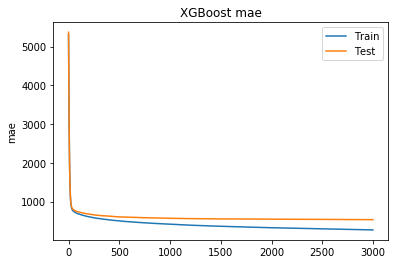

In [13]:
model = xgb_reg
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(6,4))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('mae')
pyplot.title('XGBoost mae')
plt.savefig('mae.png',dpi = 1200)
pyplot.show()

In [19]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [20]:
np.sqrt(mean_squared_error(xgb_reg.predict(X_train),y_train)),mean_absolute_error(xgb_reg.predict(X_train),y_train)

OSError: exception: access violation writing 0x0000000000000000

In [47]:
np.sqrt(mean_squared_error(xgb_reg.predict(X_test),y_test)),mean_absolute_error(xgb_reg.predict(X_test),y_test)

(1257.1427365569095, 535.65346297621)

In [43]:
param_test = {
    'max_depth': [7],
    'gamma': [5],
    'reg_alpha': [0.5, 0.7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.6, 0.7],
    'n_estimators': [3000],
    'learning_rate': [0.1,0.05]
}

gsearch = GridSearchCV(estimator=xgb.XGBRegressor(
    objective='reg:linear',
    eval_metric=["mae"],
#     tree_method='gpu_hist',
#     predictor='gpu_predictor',
#     n_gpus=-1,
    n_jobs = 8,
    min_child_weight=1.1,
    seed=42, early_stopping_rounds= 100),
    param_grid=param_test,
    iid=False,
    cv=5,
    verbose=2)
gsearch.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.3min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.8, total= 2.4min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0

[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.5, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7 
[CV]  colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0.7, total= 2.7min
[CV] colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=3000, reg_alpha=0.7, subsample=0

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 205.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    early_stopping_rounds=100,
                                    eval_metric=['mae'], gamma=0,
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1.1,
                                    missing=None, n_estimators=100, n_jobs=8,
                                    nthread=None, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=True,
                                    subsample=1),
             iid=False, n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7], 'gamma': [5],
                         'learning_rate': [0.1, 0.05], 'max_d

In [48]:
np.sqrt(mean_squared_error(gsearch.predict(X_train),y_train)),mean_absolute_error(gsearch.predict(X_train),y_train)

(383.6656067204381, 232.85432823838053)

In [49]:
np.sqrt(mean_squared_error(gsearch.predict(X_test),y_test)),mean_absolute_error(gsearch.predict(X_test),y_test)

(384.82417640314196, 233.38714276540412)

In [50]:
testA = pd.read_csv('./data/used_car_testA_20200313.csv',sep = ' ')

In [51]:
testA['notRepairedDamage'] = encoder.transform(testA['notRepairedDamage'])

In [52]:
submission = pd.read_csv('./data/used_car_sample_submit.csv')
submission['price'] = gsearch.predict(testA.drop(['SaleID','name'],axis = 1))

In [53]:
submission

,SaleID,price
0,150000,39207.699219
1,150001,256.054901
2,150002,5952.170898
3,150003,11881.668945
4,150004,653.350525
...,...,...
49995,199995,2810.412354
49996,199996,1363.564697
49997,199997,7798.590332
49998,199998,9841.564453


In [54]:
submission.to_csv('submission_3_21_xgb_grid_search.csv',index = False)

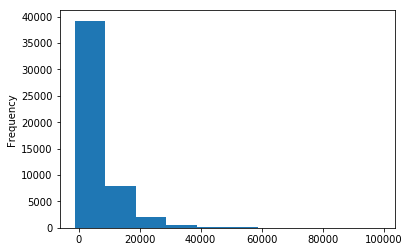

In [112]:
submission.price.plot(kind = 'hist')

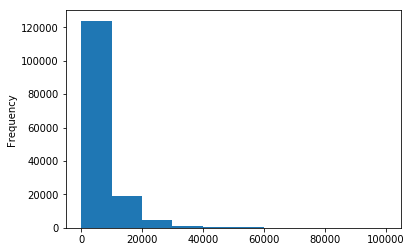

In [111]:
data.price.plot(kind = 'hist')

In [127]:
from sklearn.linear_model import LassoCV

In [172]:
Lasso_model = LassoCV(alphas= np.logspace(-2,0,30),cv= 10,normalize=True,n_jobs = -1)

In [128]:
data.isna().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [154]:
data_clean = data.fillna(value = - 1)

In [155]:
encoder = LabelEncoder()
data_clean['notRepairedDamage'] = encoder.fit_transform(data.notRepairedDamage)

In [156]:
X_train = data_clean.drop(labels= ['SaleID','price'],axis = 1)
y_train = data_clean.price

In [173]:
Lasso_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1168977065.3725586, tolerance: 765886744.099485
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1109082517.8125, tolerance: 757107620.3031857
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1202739980.8916016, tolerance: 762568417.3135406
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1453176474.1923828, tolerance: 759023716.1381336
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1482306917.928711, tolerance: 762795490.0382618
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2343626013.6835938, tolerance: 759023716.1381336
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

LassoCV(alphas=array([0.01      , 0.01172102, 0.01373824, 0.01610262, 0.01887392,
       0.02212216, 0.02592944, 0.03039195, 0.03562248, 0.04175319,
       0.04893901, 0.05736153, 0.06723358, 0.07880463, 0.09236709,
       0.10826367, 0.1268961 , 0.14873521, 0.17433288, 0.20433597,
       0.23950266, 0.28072162, 0.32903446, 0.38566204, 0.45203537,
       0.52983169, 0.62101694, 0.72789538, 0.85316785, 1.        ]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=-1, normalize=True, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [174]:
np.sqrt(mean_squared_error(Lasso_model.predict(X_train),y_train)),mean_absolute_error(Lasso_model.predict(X_train),y_train)

(4293.747968899664, 2671.8252315847626)

In [194]:
rf = RandomForestClassifier(max_depth=6, random_state=0,n_estimators=50,n_jobs = 8, verbose = 1)

In [181]:
data_clean  = data_clean.fillna(value = -1)

In [182]:
X_train,X_test,y_train,y_test = train_test_split(data_clean.drop(labels = ['SaleID','price'],axis = 1),data_clean.price, 
                                                 test_size = 0.3, random_state = 0, shuffle = True)

In [195]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   31.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=8,
                       oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [196]:
np.sqrt(mean_squared_error(rf.predict(X_train),y_train)),mean_absolute_error(rf.predict(X_train),y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
np.sqrt(mean_squared_error(rf.predict(X_test),y_test)),mean_absolute_error(rf.predict(X_test),y_test)